In [ ]:
import numpy as np
import pandas as pd

def calculate_hz(lum, teff):
    """
    Calculate the Habitable Zone for a given Stellar Effective Temperature (Teff) using the empirical formula.

    Parameters:
        lum (float or array): Stellar Luminosity in Solar Units.
        teff (float or array): Stellar Effective Temperature in Kelvin.

    Returns:
        tuple: A tuple containing the inner and outer orbit_size of the Habitable Zone in Astronomical Units (AU).
    """
    # Constants for the empirical formula
    coeff = {"inner": [1.0140, 8.1774e-5, 1.7063e-9, -4.3241e-12, -6.6462e-16],
             "outer": [0.3438, 5.8942e-5, 1.6558e-9, -3.0045e-12, -5.2983e-16]}
    teff_star = teff - 5780

    s_inner = (coeff["inner"][0] + coeff["inner"][1] * teff_star + coeff["inner"][2] * teff_star**2 +
               coeff["inner"][3] * teff_star**3 + coeff["inner"][4] * teff_star**4)
    s_outer = (coeff["outer"][0] + coeff["outer"][1] * teff_star + coeff["outer"][2] * teff_star**2 +
               coeff["outer"][3] * teff_star**3 + coeff["outer"][4] * teff_star**4)

    hz_inner = np.sqrt(lum / s_inner)
    hz_outer = np.sqrt(lum / s_outer)
    return hz_inner, hz_outer

In [2]:
toi_df = pd.read_csv("output_data/TOI_2025.08.02_05.03.17_final_predicted.csv")

In [3]:
toi_pc = toi_df[(toi_df['Prediction'] == 1) & ((toi_df['tfopwg_disp'] == 'PC') | (toi_df['tfopwg_disp'] == 'APC'))].copy()
toi_pc['tfopwg_disp'].value_counts()


tfopwg_disp
PC     2341
APC      75
Name: count, dtype: int64

In [12]:
from astroquery.gaia import Gaia
# obtain Gaia DR3 mass, luminosity, teff

gaia_id = toi_pc['gaia_source_id'].dropna().drop_duplicates()

gaia_id = gaia_id.str.replace('Gaia DR3 ', '', regex=False).values

parameter_query = ("""select sp.source_id, sp.teff_gspspec, sp.flags_gspspec, sp.lum_flame,
                    sp.mass_flame, r_med_geo, r_lo_geo, r_hi_geo, sp.flags_flame,
                    sp.teff_gspphot, g.ruwe
                    FROM gaiadr3.astrophysical_parameters AS sp
                    JOIN gaiadr3.gaia_source as g on sp.source_id = g.source_id
                    JOIN external.gaiaedr3_distance as dist on g.source_id = dist.source_id 
                    where 
                    sp.source_id in ("""+(len(gaia_id)-1)*"{},"+"{})").format(*gaia_id)

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1

job = Gaia.launch_job_async(parameter_query)
r = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
flags = r['flags_gspspec']
masks = []
for i, flag in enumerate(flags):
    if len(flag) < 1:
        masks.append(False)
        continue
    # Check condition 1: positions 1,4,8,13 are all 0
    cond1 = flag[0] == "0" and flag[3] == "0" and flag[7] == "0" and flag[12] == "0"

    if cond1:
        masks.append(True)
    else:
        masks.append(False)

masks = np.array(masks)
gspspec_results = r[masks].copy()
print(f"Number of entries after applying gspspec flags: {len(gspspec_results)}")

Number of entries after applying gspspec flags: 917


In [15]:
masks = r['ruwe'] < 1.25
gspphot_results = r[masks].copy()
print(f"Number of entries after applying ruwe < 1.25: {len(gspphot_results)}")

Number of entries after applying ruwe < 1.25: 2137


In [26]:
result_df = r.copy()
# combine the teff from gspspec and gspphot, prefer gspspec
teff = []
for i, row in r.iterrows():
    if i in gspspec_results.index:
        teff.append(row['teff_gspspec'])
    elif i in gspphot_results.index:
        teff.append(row['teff_gspphot'])
    else:
        teff.append(np.nan)
teff = np.array(teff)
result_df['teff'] = teff

In [31]:
masks = result_df['flags_flame'] == '00'
habitable_df = result_df[masks].copy()
print(f"Number of entries after applying flags_flame == 0: {len(habitable_df)}")

Number of entries after applying flags_flame == 0: 1735


In [35]:
habitable_df = habitable_df[['source_id', 'teff', 'lum_flame', 'mass_flame']].dropna()

,source_id,teff,lum_flame,mass_flame
0,16870631694208,6009.000000,11.271249,1.632783
2,8727137322879488,5320.327148,0.609506,0.841024
7,23340712007943424,6314.000000,2.295422,1.161311
8,23544671414999680,5838.000000,1.116310,0.969298
9,26809361956019968,5956.083008,1.608338,1.051477
...,...,...,...,...
2297,6789228222683761792,5351.000000,0.560150,0.843108
2298,6794693413950045952,5290.058105,0.613772,0.839941
2300,6823813081760831232,6163.000000,2.187064,1.165410
2304,6902829553611002624,4932.754395,0.308891,0.797261


In [38]:
# add "Gaia DR3 " prefix to source_id to match toi_pc gaia_source_id
habitable_df['source_id'] = 'Gaia DR3 ' + habitable_df['source_id'].astype(str)

In [41]:
# merge habitable_df with toi_pc on gaia_source_id and source_id
toi_pc_final = toi_pc.merge(habitable_df, left_on='gaia_source_id', right_on='source_id', how='inner')
print(f"Number of entries after merging with habitable stars: {len(toi_pc_final)}")

Number of entries after merging with habitable stars: 1813


In [43]:
# calculate habitable zone
hz_inner, hz_outer = calculate_hz(toi_pc_final['lum_flame'], toi_pc_final['teff'])
toi_pc_final['hz_inner'] = hz_inner
toi_pc_final['hz_outer'] = hz_outer

In [47]:
# Calculate Distance to star (R_in_AU)
# Only calculate for rows where 'mass_flame' is not NaN
a_orbit = np.cbrt((toi_pc_final['pl_orbper'] / 365.256)**2 * toi_pc_final['mass_flame'])
toi_pc_final['a_orbit'] = a_orbit

In [50]:
# Determine if the planet is in the habitable zone
def habitable_zone(row):
    if pd.isna(row['mass_flame']):
        return 'no mass_flame'
    elif row['a_orbit'] >= row['hz_inner'] and row['a_orbit'] <= row['hz_outer']:
        return 'in'
    elif row['a_orbit'] < row['hz_inner'] and (row['hz_inner'] - row['a_orbit']) <= 0.1:
        return 'close'
    elif row['a_orbit'] > row['hz_outer'] and (row['a_orbit'] - row['hz_outer']) <= 0.1:
        return 'close'
    else:
        return 'out'

In [51]:
toi_pc_final['isInHabitableZone'] = toi_pc_final.apply(habitable_zone, axis=1)

In [52]:
toi_pc_final['isInHabitableZone'].value_counts()

isInHabitableZone
out      1789
in         21
close       3
Name: count, dtype: int64

In [53]:
toi_pc_final.to_csv('output_data/TOI_2025.08.02_05.03.17_habitable_list.csv', index=False)

In [66]:
print(f"Number of potentially habitable planets: {len(toi_pc_final[toi_pc_final['isInHabitableZone'] == 'in'])}")

Number of potentially habitable planets: 21


In [ ]:
print(f"Number of potentially habitable planets with radius < 2.5 Earth orbit_size: {len(toi_pc_final[(toi_pc_final['isInHabitableZone'] == 'in') & (toi_pc_final['pl_rade'] < 2.5)])}")

Number of potentially habitable planets with radius < 2.5 Earth radii: 4


In [71]:
toi_pc_final[toi_pc_final['isInHabitableZone'] == 'in']

,toi,tid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_eqt,pl_insol,st_teff,st_logg,...,r_lo_geo,r_hi_geo,flags_flame,teff_gspphot,ruwe,teff,hz_inner,hz_outer,a_orbit,isInHabitableZone
121,1861.01,TIC 323295479,742.514275,6.574445,8486.405098,11.188824,466.029696,11.147446,5490.00,4.45000,...,134.406723,134.867172,00,5533.869141,1.157916,5713.000000,0.973920,1.677715,1.542689,in
130,1895.01,TIC 384159646,748.073942,5.065203,4627.310559,9.571052,256.919380,1.029695,6762.00,4.39031,...,204.558334,205.684296,00,6377.532715,1.066227,6377.532715,1.659832,2.779442,1.732093,in
684,4191.01,TIC 167905035,742.856116,5.648328,415.340418,2.275614,210.849927,0.467105,5816.00,4.37494,...,83.467621,83.684502,00,5693.101562,1.177053,5708.000000,1.112059,1.916118,1.577085,in
700,4298.01,TIC 146282666,722.261976,7.712630,480.796335,2.720708,231.360916,0.677144,5857.00,4.26578,...,124.078918,124.500801,00,5999.970703,1.039446,5707.000000,1.375264,2.369740,1.622460,in
724,4361.01,TIC 334632624,741.423831,5.238945,503.549408,2.776093,225.513375,0.611238,5944.00,4.30249,...,97.928513,98.277924,00,5828.903320,1.162190,5934.000000,1.274063,2.173033,1.606741,in
777,4629.01,TIC 304339227,714.697096,5.691944,457.086451,2.491011,221.098548,0.564761,6324.00,4.37047,...,91.200577,91.432213,00,5892.818359,1.002850,5975.000000,1.196354,2.036833,1.579087,in
778,4630.01,TIC 292202337,721.562219,4.593341,2177.931991,4.552124,195.751470,0.347009,6294.00,4.53886,...,84.907539,85.228172,00,5841.467285,1.047246,5696.000000,0.966000,1.665373,1.605124,in
1052,5527.01,TIC 415399713,346.161483,7.417945,727.155413,2.544994,250.890785,0.936397,5862.00,4.53012,...,143.994873,144.700943,00,5554.617676,0.998504,5468.000000,0.876742,1.527709,0.941022,in
1123,5721.01,TIC 85292615,729.482347,6.939771,819.483247,3.330945,204.575973,0.413942,5881.40,4.45955,...,138.120071,138.869080,00,5791.125977,1.062938,5821.000000,1.003522,1.720234,1.590247,in
1126,5724.01,TIC 162631539,697.403770,4.965869,448.874977,3.018726,247.600117,0.888228,6060.54,4.21457,...,50.325424,50.395695,00,6012.368164,0.904912,6009.000000,1.497565,2.545897,1.609344,in


In [72]:
# Check the column names and structure
print("Available columns:")
print(toi_pc_final.columns.tolist())
print("\nFirst few rows of habitable planets:")
habitable_planets = toi_pc_final[toi_pc_final['isInHabitableZone'] == 'in']
print(f"Shape: {habitable_planets.shape}")
print(habitable_planets.head())

Available columns:
['toi', 'tid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_eqt', 'pl_insol', 'st_teff', 'st_logg', 'st_rad', 'ra', 'dec', 'tfopwg_disp', 'fe_h', 'gaia_source_id', 'Prediction', 'source_id', 'teff_gspspec', 'flags_gspspec', 'lum_flame', 'mass_flame', 'r_med_geo', 'r_lo_geo', 'r_hi_geo', 'flags_flame', 'teff_gspphot', 'ruwe', 'teff', 'hz_inner', 'hz_outer', 'a_orbit', 'isInHabitableZone']

First few rows of habitable planets:
Shape: (21, 33)
         toi            tid   pl_orbper  pl_trandurh   pl_trandep    pl_rade  \
121  1861.01  TIC 323295479  742.514275     6.574445  8486.405098  11.188824   
130  1895.01  TIC 384159646  748.073942     5.065203  4627.310559   9.571052   
684  4191.01  TIC 167905035  742.856116     5.648328   415.340418   2.275614   
700  4298.01  TIC 146282666  722.261976     7.712630   480.796335   2.720708   
724  4361.01  TIC 334632624  741.423831     5.238945   503.549408   2.776093   

         pl_eqt   pl_insol  st_teff  st_log

In [73]:
# Check for distance and other required columns
habitable_planets = toi_pc_final[toi_pc_final['isInHabitableZone'] == 'in'].copy()

# Check what we have for the table columns:
print("Checking required columns for LaTeX table:")
print("TIC ID (tid):", 'tid' in habitable_planets.columns)
print("TOI:", 'toi' in habitable_planets.columns) 
print("Distance (r_med_geo):", 'r_med_geo' in habitable_planets.columns)
print("Stellar radius (st_rad):", 'st_rad' in habitable_planets.columns)
print("Teff:", 'teff' in habitable_planets.columns)
print("Metallicity (fe_h):", 'fe_h' in habitable_planets.columns)
print("Luminosity (lum_flame):", 'lum_flame' in habitable_planets.columns)
print("Mass (mass_flame):", 'mass_flame' in habitable_planets.columns)
print("HZ inner (hz_inner):", 'hz_inner' in habitable_planets.columns)
print("HZ outer (hz_outer):", 'hz_outer' in habitable_planets.columns)
print("Period (pl_orbper):", 'pl_orbper' in habitable_planets.columns)
print("Planet radius (pl_rade):", 'pl_rade' in habitable_planets.columns)
print("Orbital distance (a_orbit):", 'a_orbit' in habitable_planets.columns)

print("\nSample values:")
print("Distance range:", habitable_planets['r_med_geo'].min(), "-", habitable_planets['r_med_geo'].max())
print("Metallicity availability:", habitable_planets['fe_h'].notna().sum(), "out of", len(habitable_planets))

Checking required columns for LaTeX table:
TIC ID (tid): True
TOI: True
Distance (r_med_geo): True
Stellar radius (st_rad): True
Teff: True
Metallicity (fe_h): True
Luminosity (lum_flame): True
Mass (mass_flame): True
HZ inner (hz_inner): True
HZ outer (hz_outer): True
Period (pl_orbper): True
Planet radius (pl_rade): True
Orbital distance (a_orbit): True

Sample values:
Distance range: 50.359318 - 551.6815
Metallicity availability: 21 out of 21


## Complete LaTeX Table with Actual Data

The following LaTeX table contains all 21 planets found to be residing in the habitable zone of their host stars:

In [82]:
def generate_latex_table_formatted(df, show_multisystem_last=True):
    """
    Generate LaTeX table for habitable planets with proper line breaks
    
    Parameters:
    df: DataFrame with habitable planets data
    show_multisystem_last: If True, show multi-system planets at the end
    """
    
    # Get only habitable planets
    habitable = df[df['isInHabitableZone'] == 'in'].copy()
    
    # Identify multi-system planets
    multisystem_mask = df['tid'].duplicated(keep=False)
    habitable_in_multisystem_mask = habitable['tid'].isin(df['tid'][multisystem_mask])

    if show_multisystem_last:
        # Single systems first, then multi-systems
        single_systems = habitable[~habitable_in_multisystem_mask].sort_values(['toi'])
        multi_systems = habitable[habitable_in_multisystem_mask].sort_values(['tid', 'toi'])
        ordered_df = pd.concat([single_systems, multi_systems])
    else:
        ordered_df = habitable.sort_values(['toi'])
    
    # Generate LaTeX table with proper formatting and line breaks
    latex_content = """\\begin{sidewaystable}[htbp]
    \\caption{Table of Planets residing in the habitable zone of their host stars. 
        The TOI column indicates the TOI number of the planets with their properties 
        listed in the last three columns. The rest of the columns are the stellar 
        parameters of the host stars""" + (". The last few rows are objects in multi-planet systems." if show_multisystem_last and len(multi_systems) > 0 else ".") + """}
    \\label{tb:habitable_planets}
    \\centering
    \\small
    \\begin{tabular}{lcccccccccccc}
        \\toprule
        TIC  & TOI & $D$ & $R_{*}$ & $T_{\\text{eff}}$ & [Fe/H] & $L_\\star$ & $M_\\star$ & 
        $d_\\mathrm{HZ, in}$ & $d_\\mathrm{HZ, out}$ & $P$ & $R_{p}$ & $a_\\mathrm{orb}$ \\\\
        & & (PC) & $(R_{\\odot})$ & (K) & & ($L_\\odot$) & ($M_\\odot$) & 
        (AU) & (AU) & (d) & $(R_{\\oplus})$ & (AU) \\\\
        \\hline"""
    
    # Generate data rows with proper formatting
    for idx, row in ordered_df.iterrows():
        # Extract TIC number from tid (remove "TIC " prefix)
        tic_id = row['tid'].replace('TIC ', '')
        
        # Format each row with line breaks for readability
        data_row = f"""
 {tic_id} & {row['toi']:.2f} & {row['r_med_geo']:.2f} & {row['st_rad']:.3f} & {row['teff']:.0f} & {row['fe_h']:.3f} & 
        {row['lum_flame']:.3f} & {row['mass_flame']:.3f} & {row['hz_inner']:.3f} & {row['hz_outer']:.3f} & 
        {row['pl_orbper']:.2f} & {row['pl_rade']:.2f} & {row['a_orbit']:.3f} \\\\"""
        
        latex_content += data_row
    
    # Add table footer
    latex_content += """
        \\bottomrule
    \\end{tabular}
\\end{sidewaystable}"""
    
    return latex_content

# Generate the formatted table
latex_table_formatted = generate_latex_table_formatted(toi_pc_final)

# Save the formatted LaTeX table to a file
with open('output_data/habitable_planets_table_formatted.tex', 'w') as f:
    f.write(latex_table_formatted)
    
print("Generated formatted LaTeX table with line breaks")
print("Saved to: output_data/habitable_planets_table_formatted.tex")
print("\nFirst part of the formatted table:")
print("=" * 60)
print(latex_table_formatted[:800])
print("...")
print("=" * 60)

Generated formatted LaTeX table with line breaks
Saved to: output_data/habitable_planets_table_formatted.tex

First part of the formatted table:
\begin{sidewaystable}[htbp]
    \caption{Table of Planets residing in the habitable zone of their host stars. 
        The TOI column indicates the TOI number of the planets with their properties 
        listed in the last three columns. The rest of the columns are the stellar 
        parameters of the host stars. The last few rows are objects in multi-planet systems.}
    \label{tb:habitable_planets}
    \centering
    \small
    \begin{tabular}{lcccccccccccc}
        \toprule
        TIC  & TOI & $D$ & $R_{*}$ & $T_{\text{eff}}$ & [Fe/H] & $L_\star$ & $M_\star$ & 
        $d_\mathrm{HZ, in}$ & $d_\mathrm{HZ, out}$ & $P$ & $R_{p}$ & $a_\mathrm{orb}$ \\
        & & (PC) & $(R_{\odot})$ & (K) & & ($L_\odot$) & ($M_\odot$) & 
        (AU) & (AU) & (d) & $(R_{\oplus})$ & (AU) \\
        \hl
...


In [83]:
# Display the complete formatted LaTeX table with line breaks
print("FORMATTED LaTeX Table for Habitable Planets:")
print("=" * 70)
print(latex_table_formatted)
print("=" * 70)
print(f"\nTable contains {len(toi_pc_final[toi_pc_final['isInHabitableZone'] == 'in'])} habitable planets")
print("Formatted table saved to: output_data/habitable_planets_table_formatted.tex")

FORMATTED LaTeX Table for Habitable Planets:
\begin{sidewaystable}[htbp]
    \caption{Table of Planets residing in the habitable zone of their host stars. 
        The TOI column indicates the TOI number of the planets with their properties 
        listed in the last three columns. The rest of the columns are the stellar 
        parameters of the host stars. The last few rows are objects in multi-planet systems.}
    \label{tb:habitable_planets}
    \centering
    \small
    \begin{tabular}{lcccccccccccc}
        \toprule
        TIC  & TOI & $D$ & $R_{*}$ & $T_{\text{eff}}$ & [Fe/H] & $L_\star$ & $M_\star$ & 
        $d_\mathrm{HZ, in}$ & $d_\mathrm{HZ, out}$ & $P$ & $R_{p}$ & $a_\mathrm{orb}$ \\
        & & (PC) & $(R_{\odot})$ & (K) & & ($L_\odot$) & ($M_\odot$) & 
        (AU) & (AU) & (d) & $(R_{\oplus})$ & (AU) \\
        \hline
 323295479 & 1861.01 & 134.62 & 1.061 & 5713 & 0.380 & 
        0.957 & 0.888 & 0.974 & 1.678 & 
        742.51 & 11.19 & 1.543 \\
 384159646 & 1895.01

## LaTeX Table Formatting Improvements

The formatted version includes:

1. **Line breaks in table headers** - Column headers are split across multiple lines for better readability
2. **Line breaks in data rows** - Each data row is split into logical groups of columns 
3. **Multi-line caption** - Caption text is broken into multiple lines for easier reading
4. **Proper indentation** - Consistent indentation throughout the LaTeX code
5. **Clear structure** - Better visual separation between different parts of the table

This makes the LaTeX code much more readable and easier to edit manually if needed.

**Files generated:**
- `output_data/habitable_planets_table.tex` - Original single-line format
- `output_data/habitable_planets_table_formatted.tex` - **New formatted version with line breaks**

# multi-system with at least one habitable planet

In [58]:
# find duplicates in 'tid' column, do not drop them, and list the duplicates together
multisystem_toi = toi_pc_final[toi_pc_final['tid'].duplicated(keep=False)]

In [63]:
multisystem_habitable_toi = multisystem_toi[multisystem_toi['isInHabitableZone'] == 'in']

In [150]:
multisystem_habitable_with_companion_toi = multisystem_toi[multisystem_toi['tid'].isin(multisystem_habitable_toi['tid'])]
multisystem_habitable_with_companion_toi[['toi','tid','pl_orbper','pl_rade','a_orbit', 'teff','mass_flame','lum_flame','st_rad','r_med_geo', 'isInHabitableZone']]

,toi,tid,pl_orbper,pl_rade,a_orbit,teff,mass_flame,lum_flame,st_rad,r_med_geo,isInHabitableZone
1206,5968.01,TIC 431810418,753.822332,1.907690,1.643490,5823.0,1.042216,1.220793,1.06000,122.097893,in
1207,5968.02,TIC 431810418,9.215239,2.474780,0.087215,5823.0,1.042216,1.220793,1.06000,122.097893,out
1474,6690.01,TIC 149989864,761.709228,2.557898,1.584645,5680.0,0.914982,0.932505,1.06775,158.657303,in
1475,6690.02,TIC 149989864,904.534798,2.730663,1.777008,5680.0,0.914982,0.932505,1.06775,158.657303,out
1617,7060.01,TIC 469810663,5.849720,2.712860,0.065972,6233.0,1.119453,1.877756,1.35000,190.555450,out
1618,7060.02,TIC 469810663,1064.700399,4.451580,2.118794,6233.0,1.119453,1.877756,1.35000,190.555450,in


In [133]:
import matplotlib.pyplot as plt
import numpy as np

def create_system_plot(ax, system, max_radius=2.0):
    orbit_size = system["orbit_size"]
    hz = system["habitable_zone"]
    
    # Set equal aspect ratio and fixed scale
    ax.set_aspect('equal')
    ax.set_xlim(-max_radius, max_radius)
    ax.set_ylim(-max_radius, max_radius)
    
    # Shade habitable zone in green
    ax.add_patch(plt.Circle((0, 0), hz["Outer"], color='green', alpha=0.2, fill=True))
    ax.add_patch(plt.Circle((0, 0), hz["Inner"], color='white', alpha=1.0, fill=True))
    
    # Plot star
    ax.scatter(0, 0, color=system["star_color"], s=300, label=system["star_label"], edgecolor='black')
    
    orbit_colors = ['brown', 'orange', 'blue', 'red', 'magenta', 'cyan']
    # Plot orbits
    for i, (planet, radius) in enumerate(orbit_size.items()):
        if radius < 0.1:
            radius = 0.2
        orbit = plt.Circle((0, 0), radius, color=orbit_colors[i], fill=False, linestyle='--', linewidth=1.5)
        ax.add_artist(orbit)
        
        # Position labels with alternating placement
        angle = 45 if list(orbit_size.keys()).index(planet) % 2 else -45
        x = radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        offset = 15 if y > 0 else -15
        ax.annotate(planet, xy=(x, y), xytext=(0, offset),
                    textcoords='offset points', ha='center', 
                    va='bottom' if y > 0 else 'top', fontsize=18, 
                    color=orbit_colors[i]),
      
    # Add legend, do not show marker, only show label   
    ax.text(0.5, 0.98, system["star_label"], transform=ax.transAxes, fontsize=20,
            ha='center', va='top')
    # remove axes
    ax.axis('off')

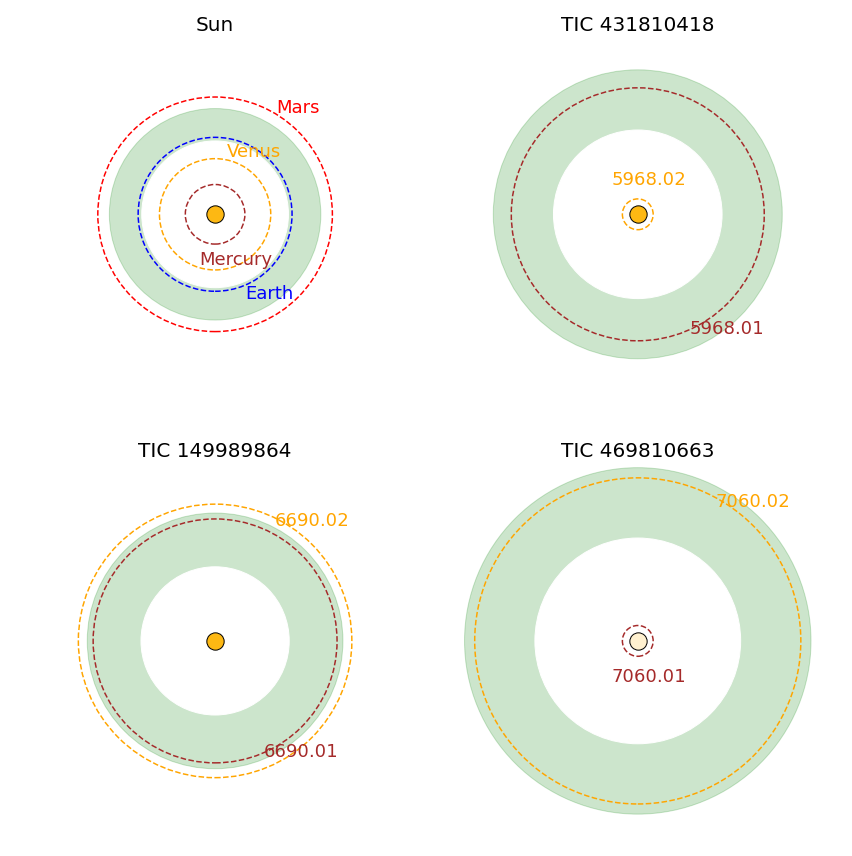

In [146]:
names = multisystem_habitable_with_companion_toi['tid'].unique()
# Data for each system
systems = [
    {
        "name": "Solar System",
        "orbit_size": {
            "Mercury": 0.387,
            "Venus": 0.723,
            "Earth": 1.0,
            "Mars": 1.524
        },
        "habitable_zone": {
            "Inner": 0.953,
            "Outer": 1.374
        },
        "star_color": "#FDB813",
        "star_label": "Sun",
        "title": "a)"
    },
    {
        "name": names[0],
        "orbit_size": {
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['toi'].values[0]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['a_orbit'].values[0],
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['toi'].values[1]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['a_orbit'].values[1],
        },
        "habitable_zone": {
            "Inner": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['hz_inner'].values[0],
            "Outer": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[0]]['hz_outer'].values[0]
        },
        "star_color": "#FDB813",
        "star_label": names[0],
        "title": "b)"
    },
    {
        "name": names[1],
        "orbit_size": {
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['toi'].values[0]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['a_orbit'].values[0],
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['toi'].values[1]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['a_orbit'].values[1],
        },
        "habitable_zone": {
            "Inner": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['hz_inner'].values[0],
            "Outer": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[1]]['hz_outer'].values[0]
        },
        "star_color": "#FDB813",
        "star_label": names[1],
        "title": "c)"
    },
    {
        "name": names[2],
        "orbit_size": {
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['toi'].values[0]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['a_orbit'].values[0],
            multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['toi'].values[1]: multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['a_orbit'].values[1],
        },
        "habitable_zone": {
            "Inner": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['hz_inner'].values[0],
            "Outer": multisystem_habitable_with_companion_toi[multisystem_habitable_with_companion_toi['tid'] == names[2]]['hz_outer'].values[0]
        },
        "star_color": "#FFF1D0",
        "star_label": names[2],
        "title": "d)"
    }
]

# Create figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12), facecolor='white')

# Determine maximum radius across all systems for consistent scaling
max_orbit = max(max(sys["orbit_size"].values()) for sys in systems)
max_hz = max(sys["habitable_zone"]["Outer"] for sys in systems)
max_radius = max(max_orbit, max_hz) * 1.2

# Create each plot
for i, system in enumerate(systems):
    create_system_plot(axs.flatten()[i], system, max_radius=max_radius)

# Adjust layout with minimal space between subplots, reduce horizontal space
plt.tight_layout()

# Save and show
plt.savefig("figures/uniform_scale_systems_with_hz.pdf")
plt.show()